In [88]:
from pathlib import Path
import glob

import random
import math

import numpy as np
from numba import njit, prange

import matplotlib.pyplot as plt
from PIL import Image

In [89]:
def load_images(path: Path, thumbnail_shape: tuple) -> list[np.ndarray]:
    files = glob.glob(path.as_posix())
    images = []
    for f in files:
        img = Image.open(f).convert('L')
        img.thumbnail(thumbnail_shape, Image.Resampling.BICUBIC)
        img = np.array(img)
        img = -1+(img-img.min())/(img.max()-img.min())*(1-(-1))
        images.append(img)
    return images

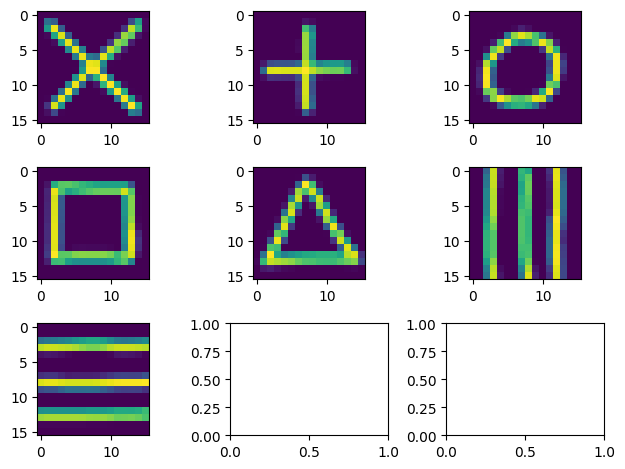

In [90]:
data = load_images(Path('..' , '..', 'data', 'images', 'shapes', '*'), (16, 16))

fig, axes = plt.subplots(nrows=3, ncols=3)

for i,ax in enumerate(axes.ravel()):
    if i < len(data):
        img = ax.imshow(data[i], cmap='viridis')
        
plt.tight_layout()
plt.show()

In [91]:
@njit(fastmath=True)
def fit(data: np.ndarray, n: int) -> np.ndarray:
    w = np.zeros((n, n))
    for i in prange(data.shape[0]):
        w += data[i]*data[i].reshape((n, 1))
    return w/n*(1-np.eye(n))


@njit(fastmath=True)
def reconstruct(x: np.ndarray, w: np.ndarray, n: int, niter: int) -> np.ndarray:
    for i in prange(niter):
        idxs = np.random.permutation(n)
        for idx in idxs:
            # x[idx] = 1 if np.dot(w[idx], x) >= 0 else -1
            x[idx] = max(-1, min(np.dot(w[idx], x), 1))
    return x


class HopfieldNetwork:
    def __init__(self, n: int) -> None:
        self.n: int = n
        self.memshape: tuple = (n, n)
        self.w: np.ndarray = np.zeros((n, n))

    def learn(self, data: list[np.ndarray]):
        w = fit(np.array([d.flatten() for d in data]), self.n)
        self.w = w

    def reconstruct(self, x: np.ndarray, niter: int):
        return reconstruct(x.flatten(), self.w, self.n, niter)

In [92]:
n = 16*16
memshape = (n, n)

In [93]:
model = HopfieldNetwork(n)

for i in range(1):
    model.learn([data[2]])

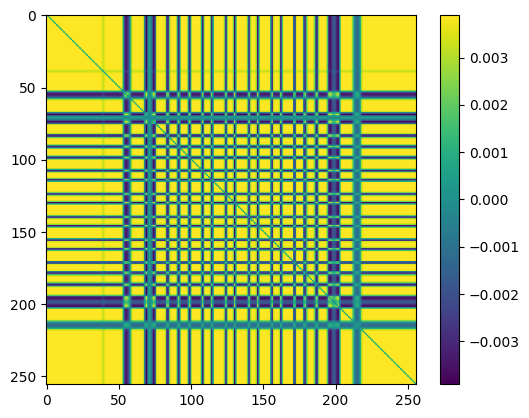

In [94]:
img = plt.imshow(model.w, cmap='viridis')
plt.colorbar(img)
plt.show()

Energy:  65.63138946048048


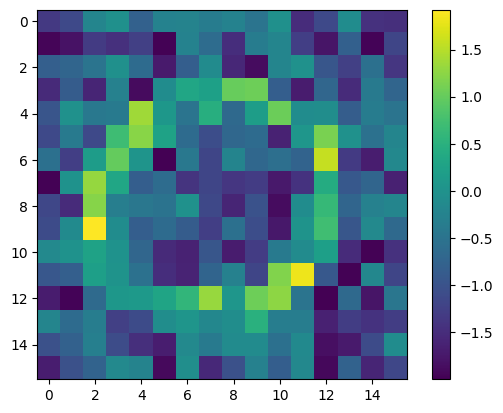

Energy:  2.7075902885531926


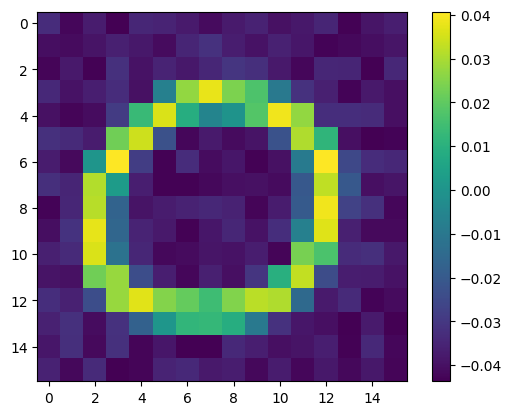

In [95]:
noise_amp = 1

x = data[2]+np.random.uniform(-noise_amp, noise_amp, (16, 16))
y = model.reconstruct(x.flatten(), 10)

print('Energy: ', -1/2*np.sum(np.dot(model.w, x.ravel())))
img = plt.imshow(x, cmap='viridis')
plt.colorbar(img)
plt.show()

print('Energy: ', -1/2*np.sum(np.dot(model.w, y)))
img = plt.imshow(y.reshape((16, 16)), cmap='viridis')
plt.colorbar(img)
plt.show()